In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import MultiLabelBinarizer

import glob
import os

In [2]:
part1 = pd.read_json('./comf/Natsumatsuri_24h_part1.json')
part2 = pd.read_json('./comf/Natsumatsuri_24h_part2.json')
part3 = pd.read_json('./comf/Natsumatsuri_24h_part3.json')
part1['Part'] = 'Part 1'
part2['Part'] = 'Part 2'
part3['Part'] = 'Part 3'
data = pd.concat((part1, part2, part3), ignore_index=True)

X = data.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'selfAnswer', 'fromList', 'gameMode', 'correct'], axis=1).copy()

In [3]:
def find_n_correct(players):
    i = 0
    for player in players:
        if player['correct'] == True:
            i += 1
    return i

def find_gt(players):
    guess_times = [x['guessTime'] for x in players if 'guessTime' in x]
    return np.array(guess_times).mean()

def find_ng(players):
    no_guess = np.zeros(len(players))
    for i, x in enumerate(players):
        val = 0
        if x['active'] == True:
            if 'guessTime' in x:
                val = 0
            else:
                val = 1
        else:
            continue
        no_guess[i] = val
    return no_guess.sum()

def find_cgt(players):
    guess_times = np.array([x['guessTime'] for x in players if ('guessTime' in x and x['correct'] == True)])
    return np.array(guess_times).mean()

def find_igt(players):
    guess_times = np.array([x['guessTime'] for x in players if ('guessTime' in x and x['correct'] == False)])
    return np.array(guess_times).mean()

def find_scores(players):
    scores = np.zeros(len(players))
    for i, x in enumerate(players):
        scores[i] = x['score']
    return scores

X['avgGuessTime'] = X['players'].apply(find_gt)
X['n_correctGuess'] = X['players'].apply(find_n_correct)
X['n_noGuess'] = X['players'].apply(find_ng)
X['p_noGuess'] = X['n_noGuess']/X['totalPlayers'] *100
X['p_correctGuess'] = X['n_correctGuess']/X['totalPlayers']*100
X['avgGuessTime_c'] = X['players'].apply(find_cgt)
X['avgGuessTime_i'] = X['players'].apply(find_igt)
X['type_noNumber'] = X['type'].str.split().str[0]
X['samplePercent'] = X['startSample']/X['videoLength']
X['AiredDate'] = X['vintage'].replace({'Winter': '1', 'Spring': '4', 'Summer': '7', 'Fall': '10'}, regex=True)
X['AiredDate'] = pd.to_datetime(X['AiredDate'], format='%m %Y')

songs_played = X.shape[0]
guess_rate = X['p_correctGuess'].mean()
guess_time = X['avgGuessTime'].mean()
no_guess_rate = X['p_noGuess'].mean()
diff = X['difficulty'].mean()

op = X.loc[X['type_noNumber'] == 'Opening']
op_played = op.shape[0]
op_rate = op['p_correctGuess'].mean()
op_diff = op['difficulty'].mean()

ed = X.loc[X['type_noNumber'] == 'Ending']
ed_played = ed.shape[0]
ed_rate = ed['p_correctGuess'].mean()
ed_diff = ed['difficulty'].mean()

ins = X.loc[X['type_noNumber'] == 'Insert']
in_played = ins.shape[0]
in_rate = ins['p_correctGuess'].mean()
in_diff = ins['difficulty'].mean()

last_song = pd.DataFrame(X.loc[X['songNumber'] == 20]).reset_index(drop=True)
last_song['Scores'] = last_song['players'].apply(find_scores)
n_games = len(last_song)

finalScores = np.concatenate(last_song['Scores'].values).astype(int)
end_mean = finalScores.mean()
end_std = finalScores.std()
end_max = finalScores.max()

mlb = MultiLabelBinarizer()
s = X['tags']
dummy = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

mlb2 = MultiLabelBinarizer()
s = X['genre']
dummy = pd.DataFrame(mlb2.fit_transform(s), columns=mlb2.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

X = X.drop(['tags', 'genre'], axis=1)

genres = X[mlb2.classes_].sum().sort_values(ascending=False)
g_perc = pd.Series(index=mlb2.classes_, dtype='float64')
for genre in mlb2.classes_:
    g_perc[genre] = X.loc[X[genre] == 1]['p_correctGuess'].mean()
genres = pd.concat([genres, g_perc], axis=1)
genres.columns = ['Count', 'Guess rate']
genres = genres.sort_values(by='Guess rate', ascending=False)

tags = X[mlb.classes_].sum().sort_values(ascending=False)
t_perc = pd.Series(index=mlb.classes_, dtype='float64')
for tag in mlb.classes_:
    t_perc[tag] = X.loc[X[tag] == 1]['p_correctGuess'].mean()
tags = pd.concat([tags, t_perc], axis=1)
tags.columns = ['Count', 'Guess rate']
tags = tags.sort_values(by='Count', ascending=False).head(30).sort_values(by='Guess rate', ascending=False)

/var/folders/7h/lb5014td1szbmsjlhhy0swz00000gn/T/ipykernel_668/896848299.py:10: RuntimeWarning: Mean of empty slice.
  return np.array(guess_times).mean()
/var/folders/7h/lb5014td1szbmsjlhhy0swz00000gn/T/ipykernel_668/896848299.py:28: RuntimeWarning: Mean of empty slice.
  return np.array(guess_times).mean()
/var/folders/7h/lb5014td1szbmsjlhhy0swz00000gn/T/ipykernel_668/896848299.py:32: RuntimeWarning: Mean of empty slice.
  return np.array(guess_times).mean()


In [4]:
general_table = [
    ['Games played', n_games],
    ['Songs played', songs_played],
    ['Correct guess rate (%)', '{:.2f}'.format(guess_rate)],
    ['Average difficulty', '{:.2f}'.format(diff)],
    ['Average guess time (s)', '{:.2f}'.format(guess_time/1000)],
    ['No guess rate (%)', '{:.2f}'.format(no_guess_rate)]
]
print(tabulate(general_table, tablefmt='fancy_grid'))

types_table = {
    'Openings': [op_played, op_rate, op_diff],
    'Endings': [ed_played, ed_rate, ed_diff],
    'Inserts': [in_played, in_rate, in_diff]
}
print(tabulate(types_table, tablefmt='fancy_grid', headers='keys', showindex=[
    'Songs played', 'Correct guess rate (%)', 'Average difficulty']
              ))

ends_table = {
    'Final score': ['{:.2f}'.format(end_mean), '{:.2f}'.format(end_std), end_max]
}
print(tabulate(ends_table, tablefmt='fancy_grid', headers='keys', showindex=[
    'Mean', 'STD', 'Highest']
              ))

╒════════════════════════╤═════════╕
│ Games played           │  103    │
├────────────────────────┼─────────┤
│ Songs played           │ 2060    │
├────────────────────────┼─────────┤
│ Correct guess rate (%) │   42.26 │
├────────────────────────┼─────────┤
│ Average difficulty     │   37.39 │
├────────────────────────┼─────────┤
│ Average guess time (s) │    9.51 │
├────────────────────────┼─────────┤
│ No guess rate (%)      │   41.68 │
╘════════════════════════╧═════════╛
╒════════════════════════╤════════════╤═══════════╤═══════════╕
│                        │   Openings │   Endings │   Inserts │
╞════════════════════════╪════════════╪═══════════╪═══════════╡
│ Songs played           │   888      │  864      │  308      │
├────────────────────────┼────────────┼───────────┼───────────┤
│ Correct guess rate (%) │    50.8571 │   37.9387 │   29.6266 │
├────────────────────────┼────────────┼───────────┼───────────┤
│ Average difficulty     │    43.4235 │   32.9066 │   32.5523 │
╘══════

In [5]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def find_jp(names):
    if 'romaji' in names:
        name = names['romaji']
    else:
        raise Exception('No jp name')
    return name
X['anime_jp'] = X['anime'].apply(find_jp)

lbs = {'difficulty':'Difficulty',
      'artist':'Artist',
      'name':'Song',
      'p_correctGuess':'Correct percent',
      'p_noGuess':'No guess percent',
      'anime_jp':'Anime',
      'avgGuessTime':'Average guess time',
      'AiredDate': 'Aired date',
      'avgGuessTime_c':'Correct avg. guess time',
      'avgGuessTime_i':'Incorrect avg. guess time',
      'type_noNumber':'Song type'}

hover_dt = {'artist':True,
           'name':True,
           'anime_jp':True,
           'avgGuessTime':True,
           'difficulty':':.1f',
           'p_noGuess':':.1f',
           'p_correctGuess':':.1f',
           'avgGuessTime':':.1f',
           'avgGuessTime_c':':.1f',
           'avgGuessTime_i':':.1f',}

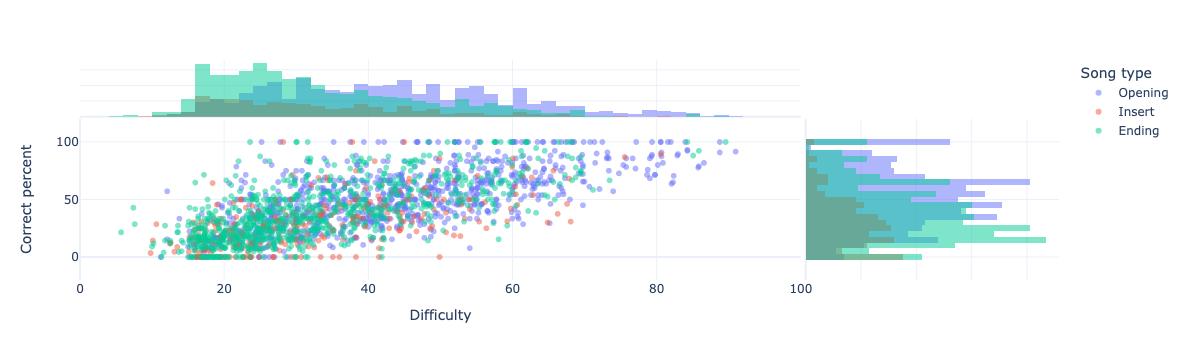

In [6]:
px.scatter(
        X,
        x='difficulty',
        y='p_correctGuess',
        color='type_noNumber',
        marginal_x='histogram', 
        marginal_y='histogram',
        hover_data=hover_dt,
        labels=lbs,
        template='plotly_white',
        range_x=[0, 100],
        range_y=[-20, 120],
        opacity=0.5
        )

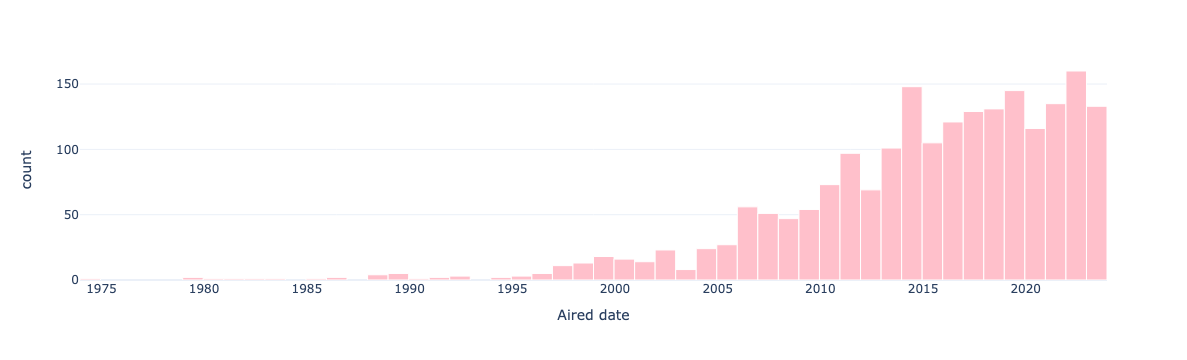

In [8]:
fig = px.histogram(X, x='AiredDate', labels=lbs, template='plotly_white', color_discrete_sequence=['pink'])
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.show()

/var/folders/7h/lb5014td1szbmsjlhhy0swz00000gn/T/ipykernel_668/2483544830.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



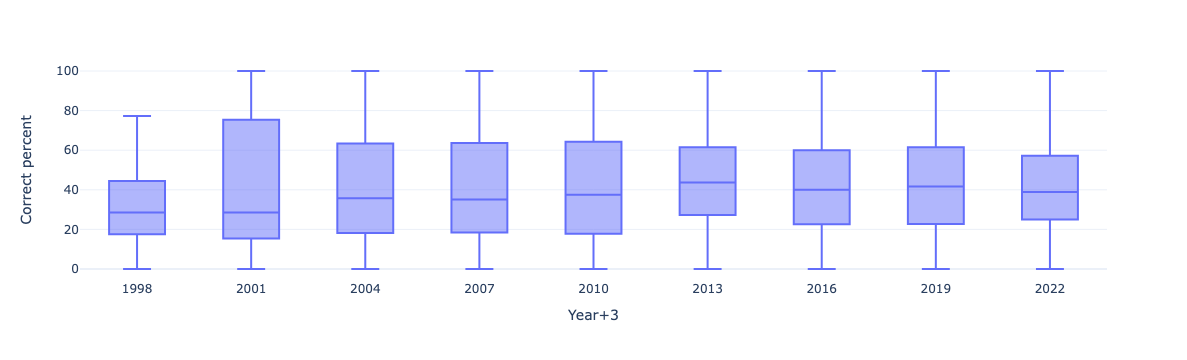

In [9]:
modern = X.loc[X['AiredDate'].dt.year > 1997]
modern['Year+3'] = modern['AiredDate'].dt.year//3*3
px.box(modern, x='Year+3', y='p_correctGuess', template='plotly_white', labels=lbs)

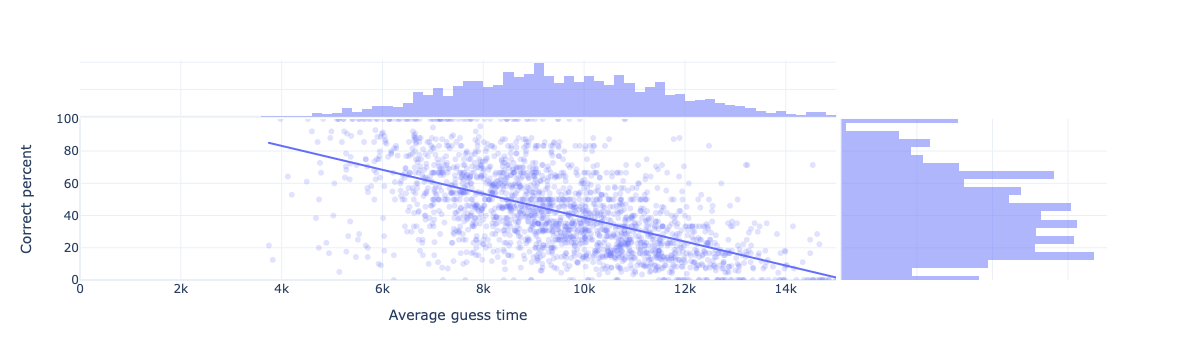

In [10]:
px.scatter(
        X,
        x='avgGuessTime',
        y='p_correctGuess',
        hover_data=hover_dt,
        marginal_x='histogram', 
        marginal_y='histogram',
        labels=lbs,
        trendline='ols',
        template='plotly_white',
        range_x=[0, 15000],
        range_y=[0, 100],
        opacity=0.2
        )

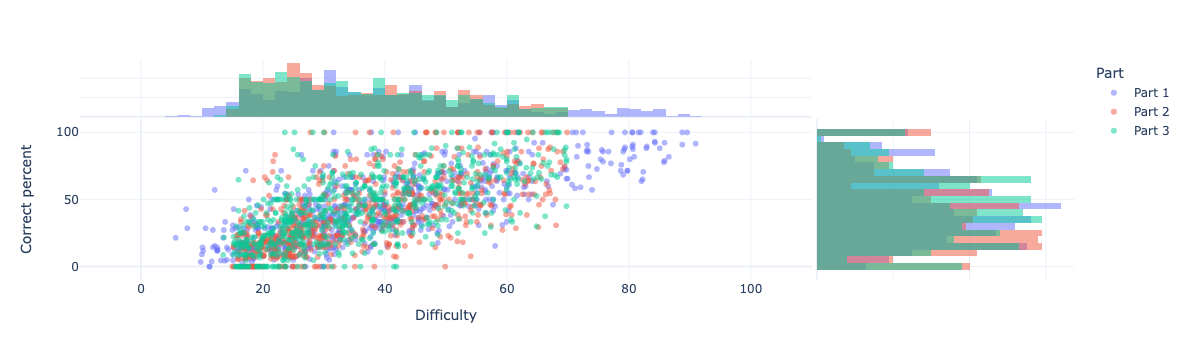

In [11]:
px.scatter(
        X,
        x='difficulty',
        y='p_correctGuess',
        color='Part', 
        marginal_x='histogram', 
        marginal_y='histogram',
        hover_data=hover_dt,
        labels=lbs,
        template='plotly_white',
        range_x=[-10, 110],
        range_y=[-10, 110],
        opacity=0.5
        )

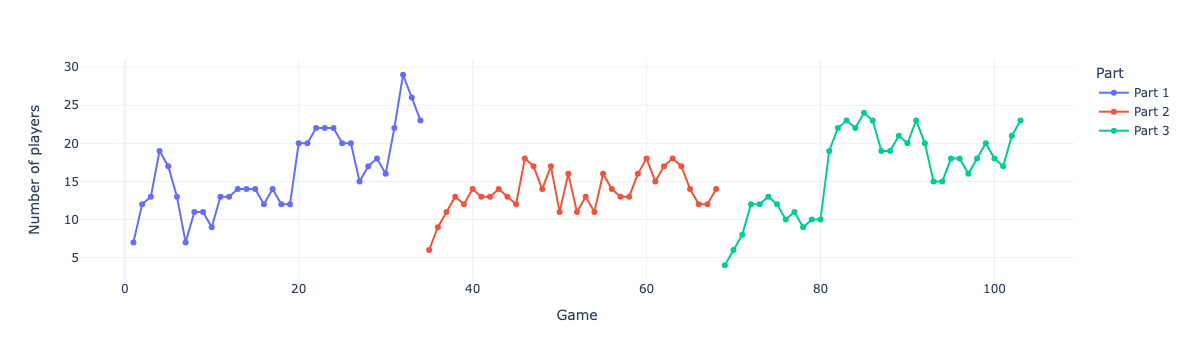

In [12]:
px.line(last_song,
        x=last_song.index+1,
        y='totalPlayers',
        markers=True,
        template='plotly_white',
        color='Part',
        labels={'totalPlayers':'Number of players', 'x':'Game'} )

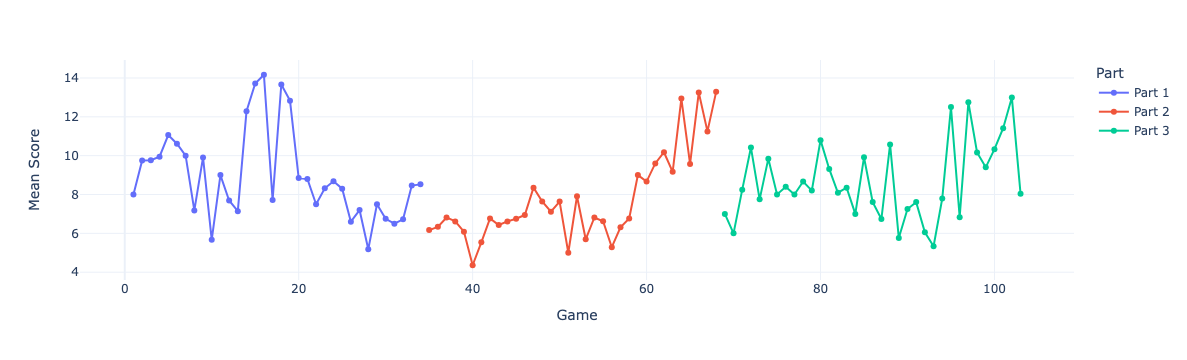

In [13]:
px.line(last_song,
        x=last_song.index+1,
        y=last_song['Scores'].apply(np.mean),
        markers=True,
        template='plotly_white',
        color='Part',
        labels={'y':'Mean Score', 'x':'Game'} )

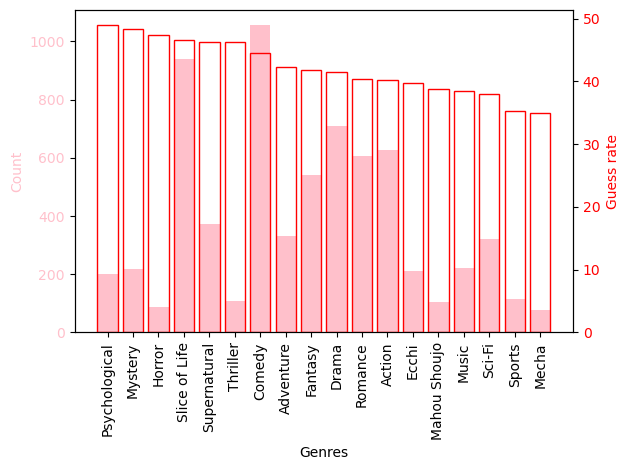

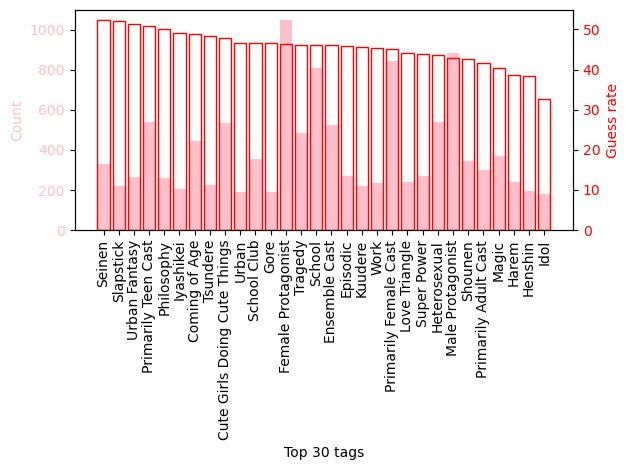

In [36]:
f, ax_p = plt.subplots()
color = 'pink'
ax_p.set_xlabel('Genres')
ax_p.set_ylabel('Count', color=color)
ax_p.bar(genres['Count'].keys().tolist(), genres['Count'], color=color)
ax_p.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax_c = ax_p.twinx()

color = 'red'
ax_c.set_ylabel('Guess rate', color=color)
ax_c.bar(genres['Count'].keys().tolist(), genres['Guess rate'], edgecolor=color, fill=False)
ax_c.tick_params(axis='y', labelcolor=color)

f.tight_layout()
plt.savefig('genres.png')
plt.show()


f, ax_p = plt.subplots()
color = 'pink'
ax_p.set_xlabel('Top 30 tags')
ax_p.set_ylabel('Count', color=color)
ax_p.bar(tags['Count'].keys().tolist(), tags['Count'], color=color)
ax_p.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax_c = ax_p.twinx()

color = 'red'
ax_c.set_ylabel('Guess rate', color=color)
ax_c.bar(tags['Count'].keys().tolist(), tags['Guess rate'], edgecolor=color, fill=False)
ax_c.tick_params(axis='y', labelcolor=color)

f.tight_layout()
plt.savefig('tags.png')
plt.show()

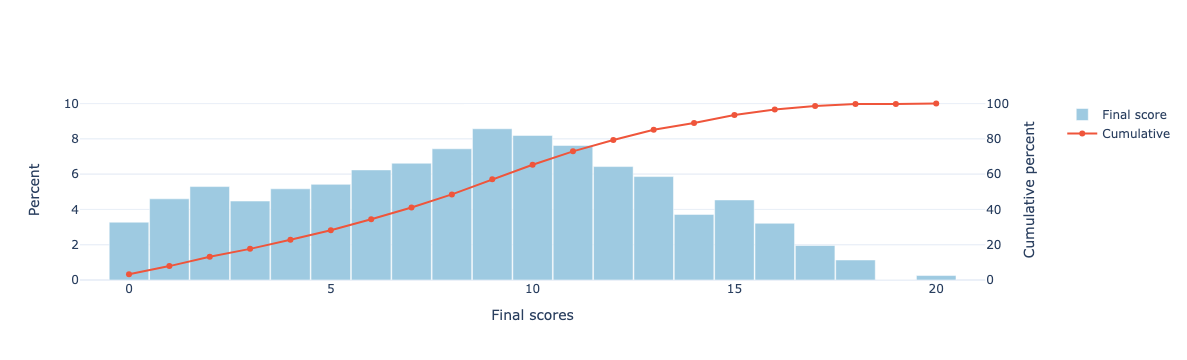

In [35]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

hist = np.histogram(finalScores, bins=np.arange(22)-0.01)[0]
hist_density = np.histogram(finalScores, bins=np.arange(22)-0.01, density=True)[0]*100
fig.add_trace(
    go.Bar(x=np.arange(0, 21), y=hist_density, name='Final score', width=0.98),
    secondary_y=False,
)
fig.update_traces(marker_color='rgb(158,202,225)')
fig.add_trace(
    go.Scatter(x=np.arange(0, 21), y=hist_density.cumsum() ,mode='lines+markers', name='Cumulative'),
    secondary_y=True,
)
fig.update_layout(template='plotly_white', yaxis=dict(
        title=dict(text='Percent'),
        side='left',
        range=[0, 10.2],
    ),
    yaxis2=dict(
        title=dict(text='Cumulative percent'),
        side='right',
        range=[0, 102],
        overlaying='y',
        tickmode='auto',
    ),)
fig.update_xaxes(title_text='Final scores')
fig